<a href="https://colab.research.google.com/github/Arghavankas2022/NMA/blob/main/CALMS21_Analysis_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Modules and Data

In [ ]:
## Importing necessary modules

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Download and unzip the data
import os, requests, zipfile

fname = 'task1_classic_classification.zip'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/task1_classic_classification.zip?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
else:
  print('Data have already been downloaded!!!')

if not os.path.exists('task1_classic_classification'):
  # Unzip the file
  with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall('.')


# Download the script
fname = 'calms21_convert_to_npy.py'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/calms21_convert_to_npy.py?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

Data have already been downloaded!!!


In [ ]:
# Save the data
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.'

Saving ./calms21_task1_test


In [ ]:
# Defining and running the load data function
def load_task1_data(data_path):
  """
  Load data for task 1:
      The vocaubulary tells you how to map behavior names to class ids;
      it is the same for all sequences in this dataset.
  """
  data_dict = np.load(data_path, allow_pickle=True).item()
  dataset = data_dict['annotator-id_0']
  # Get any sequence key.
  sequence_id = list(data_dict['annotator-id_0'].keys())[0]
  vocabulary = data_dict['annotator-id_0'][sequence_id]['metadata']['vocab']
  return dataset, vocabulary

training_data, vocab = load_task1_data('./calms21_task1_train.npy')
test_data, _ = load_task1_data('./calms21_task1_test.npy')

# Data Wrangling

In [ ]:
# Filter datasets to those >8min

def filter_sequences_by_frame_count(dataset, min_frame_count):
    filtered_dataset = {}
    for k, v in dataset.items():
        if len(v['annotations']) > min_frame_count:
            filtered_dataset[k] = {
                'annotations': list(v['annotations']),
                'keypoints': v['keypoints'],
                'scores': list(v['scores']),
                'metadata': list(v['metadata'])
                            }
    return filtered_dataset

frame_count = 10000
filter_data = filter_sequences_by_frame_count(training_data, frame_count)

In [ ]:
# Reduce datasets to length 8min

for key in filter_data:
    filter_data[key]['annotations'] = filter_data[key]['annotations'][:frame_count]
    filter_data[key]['keypoints'] = filter_data[key]['keypoints'][:frame_count]

In [ ]:
# Recode aggression to 1 and any other behaviour to 0

def recode_data(dataset, behaviour):
    recode = {}

    # Iterate through each key in the dataset
    for key in dataset:
        recode[key] = []
        # Iterate through each annotation for the current key
        for item in dataset[key]['annotations']:
            if item == behaviour:
                recode[key].append(1)
            else:
                recode[key].append(0)

    return recode

aggression = recode_data(filter_data, 0)
investigation = recode_data(filter_data, 1)
mount = recode_data(filter_data, 2)
other = recode_data(filter_data, 3)

# Graphing Likelihood

In [ ]:
# Defining and running function which extracts the mean behaviour for each frame

def mean_behaviour(dataset):

    # Determine the maximum length of lists in the dictionary

    # Initialize a list to hold sums and counts for each position
    sums = [0] * frame_count
    counts = [0] * frame_count

    # Iterate through each list and update sums and counts
    for lst in dataset.values():
        for i, value in enumerate(lst):
            sums[i] += value
            counts[i] += 1

    # Calculate the mean for each position
    means = np.zeros(frame_count)
    for i in range(frame_count):
        means[i] = sums[i] / counts[i]

    return means

aggression_mean = mean_behaviour(aggression)
investigation_mean = mean_behaviour(investigation)
mount_mean = mean_behaviour(mount)

In [ ]:
# Plotting the mean of each behaviour

plt.figure()
t = range(frame_count)

ax1 = plt.subplot(3,1,1)
plt.plot(t, aggression_mean)
plt.ylabel('Aggression Probability')

plt.subplot(3,1,2, sharex=ax1)
plt.plot(t, investigation_mean)
plt.ylabel('Investigation Probability')

plt.subplot(3,1,3, sharex=ax1)
plt.plot(t, mount_mean)
plt.ylabel('Mount Probability')

plt.tight_layout()

# Calculating Features

In [ ]:
# Defining and running normalising function

def normalize_data(orig_pose_dictionary, rotate=False):
  for key in orig_pose_dictionary:
    X = orig_pose_dictionary[key]['keypoints']
    if rotate:
      X = X.transpose((0, 1, 3, 2))  # last axis is x, y coordinates
      X[..., 0] = X[..., 0]/1024
      X[..., 1] = X[..., 1]/570
    else:
      X[:, :, 0, :] = X[:, :, 0, :] / 1024
      X[: ,:, 1, :] = X[:, :, 1, :] / 570
    orig_pose_dictionary[key]['keypoints'] = X
  return orig_pose_dictionary

normalize_data(filter_data)

In [ ]:
# Calculating velocity

def calculate_velocity(dataset, mouse):

  velocity={}

  for i in list(dataset.keys()):
    keypoints = dataset[i]['keypoints']
    velocity[i] = []

    for j in range(len(keypoints)-1): ## We've iterated through each sequence. Now within each sequence

      neck_x_1 = keypoints[j, mouse, 0, 3]
      l_hip_x_1 = keypoints[j, mouse, 0,4]
      r_hip_x_1 = keypoints[j, mouse, 0,5]
      tail_x_1 = keypoints[j, mouse, 0, 6]

      neck_y_1 = keypoints[j, mouse, 1, 3]
      l_hip_y_1 = keypoints[j, mouse, 1,4]
      r_hip_y_1 = keypoints[j, mouse, 1,5]
      tail_y_1 = keypoints[j, mouse, 1, 6]

      centroid_x_1 = (neck_x_1 + l_hip_x_1 + r_hip_x_1 + tail_x_1)/4
      centroid_y_1 = (neck_y_1 + l_hip_y_1 + r_hip_y_1 + tail_y_1)/4

      neck_x_2 = keypoints[j+1, mouse, 0, 3]
      l_hip_x_2 = keypoints[j+1, mouse, 0,4]
      r_hip_x_2 = keypoints[j+1, mouse, 0,5]
      tail_x_2 = keypoints[j+1, mouse, 0, 6]

      neck_y_2 = keypoints[j+1, mouse, 1, 3]
      l_hip_y_2 = keypoints[j+1, mouse, 1,4]
      r_hip_y_2 = keypoints[j+1, mouse, 1,5]
      tail_y_2 = keypoints[j+1, mouse, 1, 6]

      centroid_x_2 = (neck_x_2 + l_hip_x_2 + r_hip_x_2 + tail_x_2)/4
      centroid_y_2 = (neck_y_2 + l_hip_y_2 + r_hip_y_2 + tail_y_2)/4

      distance_x = np.abs(centroid_x_2 - centroid_x_1)
      distance_y = np.abs(centroid_y_2 - centroid_y_1)

      vel = (distance_x**2 + distance_y**2)**.5
      velocity[i].append(vel)

  return velocity

mouse_1 = 0
velocity = calculate_velocity(filter_data, mouse_1)

In [ ]:
def mean_velocity(dataset):

    # Determine the maximum length of lists in the dictionary

    # Initialize a list to hold sums and counts for each position
    sums = [0] * (9999)
    counts = [0] * (9999)

    # Iterate through each list and update sums and counts
    for lst in dataset.values():
        for i, value in enumerate(lst):
            sums[i] += value
            counts[i] += 1

    # Calculate the mean for each position
    means = np.zeros(frame_count)
    for i in range(9999):
        means[i+1] = sums[i] / counts[i]

    return means

av_vel = mean_velocity(velocity)

ValueError: num must be an integer with 1 <= num <= 3, not 4

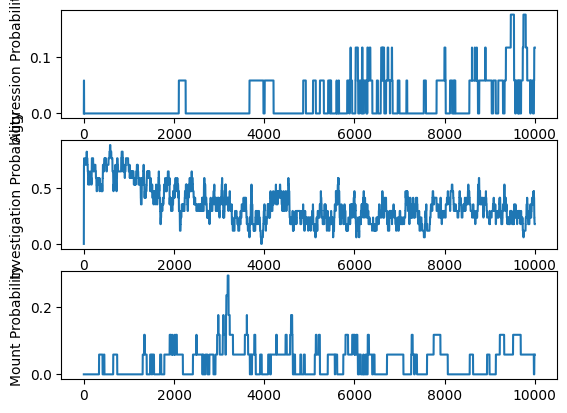

In [ ]:
plt.figure()
t = range(frame_count)

ax1 = plt.subplot(3,1,1)
plt.plot(t, aggression_mean)
plt.ylabel('Aggression Probability')

plt.subplot(3,1,2, sharex=ax1)
plt.plot(t, investigation_mean)
plt.ylabel('Investigation Probability')

plt.subplot(3,1,3, sharex=ax1)
plt.plot(t, mount_mean)
plt.ylabel('Mount Probability')

plt.subplot(3,1,4, sharex=ax1)
plt.plot(t, av_vel)
plt.ylabel('Average Velocity')

plt.tight_layout()